In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc,  classification_report
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers
#%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h2>Part 1 - Exploratory Date Analysis

In [2]:
# Load the login file
file=open('ultimate_challenge/logins.json', 'r')
file_content=file.read()
file.close()
data=json.loads(file_content)
login=pd.DataFrame(data)

In [3]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [5]:
login['count']=1

In [6]:
login.index=pd.to_datetime(login['login_time'], format='%Y-%m-%d %H:%M:%S')

In [7]:
login.drop('login_time', inplace=True, axis=1)

In [8]:
login.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [9]:
login.sort_index(inplace=True)

In [14]:
login.to_csv('ultimate_challenge/login.csv')

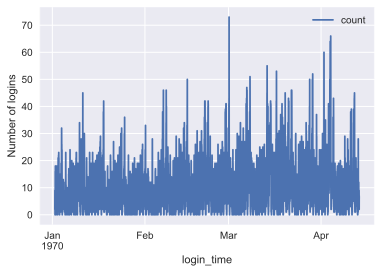

In [10]:
login.resample('15T').count().plot()
plt.ylabel('Number of logins')
plt.show()

In [11]:
# There are these spikes that appear repeatedly. Let's zoom in to see.

In [12]:
login['day']=login.index.day

In [13]:
login.head()

,count,day
login_time,,
1970-01-01 20:12:16,1,1
1970-01-01 20:13:18,1,1
1970-01-01 20:16:10,1,1
1970-01-01 20:16:36,1,1
1970-01-01 20:16:37,1,1


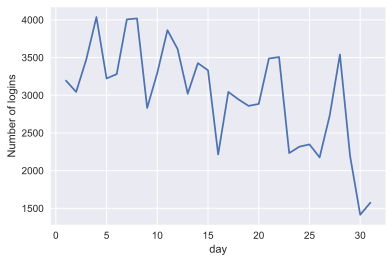

In [15]:
login.groupby('day')['count'].count().plot()
plt.xlabel('day')
plt.ylabel('Number of logins')
plt.show()

In [16]:
# Highest at the beginning of the month and lowest at the end of the month

In [17]:
login['weekday']=login.index.weekday

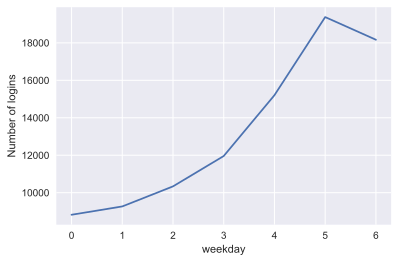

In [18]:
login.groupby('weekday')['count'].count().plot()
plt.ylabel('Number of logins')
plt.show()

In [19]:
# Saturday and Sunday have the highest logins

In [20]:
login['hour']=login.index.hour

In [21]:
login.head()

,count,day,weekday,hour
login_time,,,,
1970-01-01 20:12:16,1,1,3,20
1970-01-01 20:13:18,1,1,3,20
1970-01-01 20:16:10,1,1,3,20
1970-01-01 20:16:36,1,1,3,20
1970-01-01 20:16:37,1,1,3,20


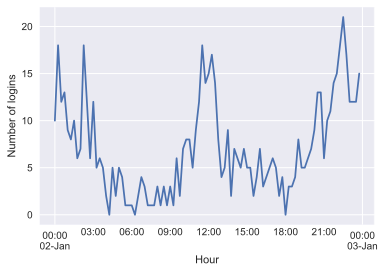

In [22]:
login['1970-01-02'].resample('15T')['count'].count().plot()
plt.xlabel('Hour')
plt.ylabel('Number of logins')
plt.show()

There are two peaks: one around noon and one late night after 11pm. Let's overlay all curves for all the daily 15 min intervals in one figure and see if they all overlap.

In [23]:
time=login.index.tolist()

In [24]:
time_str=[x.strftime(format='%Y-%m-%d %H:%M:%S')[:10] for x in time]

In [25]:
time_str[0:10]

['1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01',
 '1970-01-01']

In [26]:
login['date']=time_str

In [27]:
all_dates=login['date'].unique().tolist()

In [28]:
all_dates[0:10]

['1970-01-01',
 '1970-01-02',
 '1970-01-03',
 '1970-01-04',
 '1970-01-05',
 '1970-01-06',
 '1970-01-07',
 '1970-01-08',
 '1970-01-09',
 '1970-01-10']

In [29]:
len(all_dates)

103

In [31]:
resample_15=login['count'].resample('15T').count()

In [34]:
resample_15.head(48)

login_time
1970-01-01 20:00:00     2
1970-01-01 20:15:00     6
1970-01-01 20:30:00     9
1970-01-01 20:45:00     7
1970-01-01 21:00:00     1
1970-01-01 21:15:00     4
1970-01-01 21:30:00     0
1970-01-01 21:45:00     4
1970-01-01 22:00:00     9
1970-01-01 22:15:00     8
1970-01-01 22:30:00     1
1970-01-01 22:45:00     3
1970-01-01 23:00:00    16
1970-01-01 23:15:00    13
1970-01-01 23:30:00    14
1970-01-01 23:45:00    15
1970-01-02 00:00:00    10
1970-01-02 00:15:00    18
1970-01-02 00:30:00    12
1970-01-02 00:45:00    13
1970-01-02 01:00:00     9
1970-01-02 01:15:00     8
1970-01-02 01:30:00    10
1970-01-02 01:45:00     6
1970-01-02 02:00:00     7
1970-01-02 02:15:00    18
1970-01-02 02:30:00    12
1970-01-02 02:45:00     6
1970-01-02 03:00:00    12
1970-01-02 03:15:00     5
1970-01-02 03:30:00     6
1970-01-02 03:45:00     5
1970-01-02 04:00:00     2
1970-01-02 04:15:00     0
1970-01-02 04:30:00     5
1970-01-02 04:45:00     2
1970-01-02 05:00:00     5
1970-01-02 05:15:00     4
1

In [33]:
resample_15.tail()

login_time
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Name: count, dtype: int64

We can see that the first date and last date have missing values. Their time either doesn't start from 00:00 or end in 23:45. We will not use those two in plotting

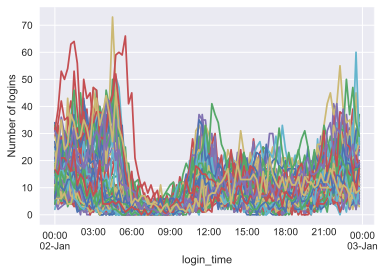

In [37]:
index_all=resample_15[all_dates[1]].index
for date in all_dates[1:102]:
    ts=resample_15[date]
    ts.index=index_all
    ts.plot()
plt.ylabel('Number of logins')
plt.show()

The three peaks seen before are present in almost all dates tested. However, there is another peak around early morning (4,5am).

<h2> Part 2 - Experiment and metrics design</h2><br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

<b>1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b><br>
I would choose driver login counts during the day and night for both cities. If the toll reimbursement startegy works, then during the day, drivers in Ultimate Gotham will travel to Ultimate Metropolis since there will be more activities. Then the day time logins in Ultimate Metropolis will increase and will decreaes in Ultimate Gotham. At night, it will be the opposite, driver logins in Ultimate Gotham will increase substantially but decrease in Ultimate Metropolis.

<b>2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
a. how you will implement the experiemnt<br>
b. what statistical test(s) you will conduct to verify the significance of the observation<br>
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.</b>
<br>
a. I will implement the experiment as follows:<br>
First, conduct the reimbursement for one month<br>
Second, record daily logins in both cities and break down by day and night<br>
Third, for each city, contruct a 2x2 contigency table as follows:<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      No reimbursement  &nbsp;&nbsp; With reimbursement<br>
Day     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     (No. logins)    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;   (No. logins)<br>
Night    &nbsp;&nbsp;&nbsp;&nbsp;    (No. logins)    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    (No. logins)<br>
The no reimbursement date will come from a previous month where the toll was still in effect. Using the contingency table, we can compare the two conditions (no reimbursement vs with reimbursement) to see if there is any difference.<br>
<br>
b. I will use Fisher Exact Test to compare the two conditions using the contingency tables. This will tell us whether the difference we observe is actually statistically significant.<br>
<br>
c. If there is clearly a difference comparing toll vs no toll (with reimbursement) both by raw numbers and statistical test, I would recommend to actually implement the reimbrusement program. <br>
If the difference is statistically significant but very marginal, then I would recommend to not implement the reimbursement because this would reduce revenue for no obvious benefit. <br>
If there is no statistical difference, then of course I would recommend to not implement the reimbursement.<br>
The caveats would be:<br>
the difference is due to other reasons such as holidays, life pattern changes, or population fluctuations.<br>
more drivers register due some campaign or events.<br>
false record due to errors when counting logins.

<h2>Part 3 - Predictive modeling

In [ ]:
file=open('ultimate_challenge/ultimate_data_challenge.json', 'r')
file_content=file.read()
file.close()
data=json.loads(file_content)
df=pd.DataFrame(data)

In [3]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
df.to_csv('ultimate_challenge/ultimate.csv')

In [8]:
# There are many missing values for the ratings, I will impute the values using mean of the columns
df_new=df.fillna(df.mean())

In [9]:
# Then fill the missing values in the phone column with 'unknown'
df_new=df_new.fillna('unknown')

In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [81]:
df_new.to_csv('ultimate_challenge/df_new.csv')

In [45]:
cohort=pd.read_csv('ultimate_challenge/df_new.csv', index_col=0)

In [46]:
cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [47]:
cohort.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0


In [49]:
cohort['last_trip_date']=pd.to_datetime(cohort['last_trip_date'], format='%Y-%m-%d')
cohort['signup_date']=pd.to_datetime(cohort['signup_date'], format='%Y-%m-%d')

In [50]:
cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


First we need to create a column with 0 representing not retained and 1 as being retained. Then explore the data based on the retention column.

In [52]:
cohort.sort_values('last_trip_date').tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
45126,6.13,4.6,4.6,1.02,Winterfell,2014-07-01,Android,2014-01-10,6.3,1,False,56.3
38651,10.19,5.0,4.9,1.00,King's Landing,2014-07-01,iPhone,2014-01-13,0.0,0,True,92.3
14473,5.06,5.0,5.0,1.00,King's Landing,2014-07-01,Android,2014-01-02,0.0,0,False,100.0
22735,8.71,5.0,5.0,1.00,Winterfell,2014-07-01,iPhone,2014-01-08,0.0,0,True,75.0
45357,3.90,4.9,4.4,1.02,Astapor,2014-07-01,iPhone,2014-01-28,1.4,5,False,76.4


The description is very vague. What exactly does it mean 'pulled several months later'? How long is several months? I would have to make some assumptions. Based on the latest last_trip_date, I assume they pulled the data on 2014-07-01. Then anyone with a last_trip_date less than 2014-06-01 will be not retained (0) and others will be retained (1).

In [57]:
cohort['retained']=cohort['last_trip_date']>='2014-06-01'

In [60]:
cohort['retained']=[int(x) for x in cohort['retained']]

In [61]:
cohort.head(2)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0


In [76]:
cohort.to_csv('ultimate_challenge/cohort.csv')

In [2]:
# 7-2-18
cohort=pd.read_csv('ultimate_challenge/cohort.csv', index_col=0)

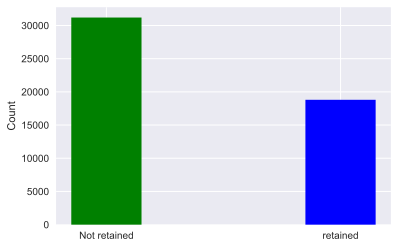

In [73]:
# Plot a bar graph to see ratio between not retained and retained
x=np.arange(2)
y=cohort['retained'].value_counts()
plt.bar(x, y, width=0.3, color=['g', 'b'])
plt.ylabel('Count')
plt.xticks(x, ['Not retained', 'retained'], rotation=0)
plt.show()

So about 1/3 of all people in the cohort retained. Not too bad. Now we can explore other features based on the retention. For categorical data, I will use bar plots and for numeric data, I will use overlayed histograms.

In [4]:
# Let's take a look at the phone types
phone=cohort.groupby('phone')['retained'].value_counts().unstack(level=0)

In [9]:
phone

phone,Android,iPhone,unknown
retained,,,
0,11876,19057,263
1,3146,15525,133


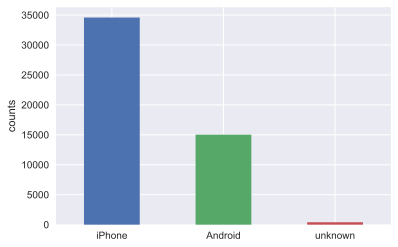

In [20]:
# How many android users and how many iphone users?
cohort['phone'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('counts')
plt.show()

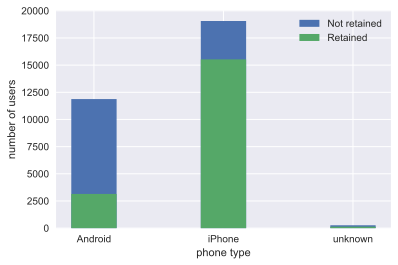

In [15]:
# See the retention rate in different phone users
N=3
ind=np.arange(N)
p1=plt.bar(ind, phone.iloc[0,:], width=0.35)
p2=plt.bar(ind, phone.iloc[1,:], width=0.35)
plt.xticks(ind, phone.columns.tolist())
plt.legend((p1[0], p2[0]), ('Not retained', 'Retained'))
plt.xlabel('phone type')
plt.ylabel('number of users')
plt.show()

Apparently iphone users are more likely to retain than android users

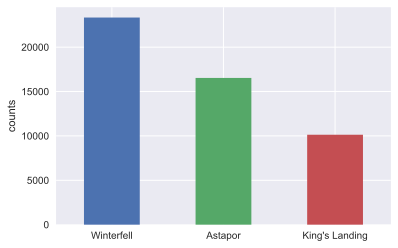

In [22]:
# Now let's look at the city distribution
cohort['city'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('counts')
plt.show()

In [23]:
# Let's take a look at the phone types
city=cohort.groupby('city')['retained'].value_counts().unstack(level=0)

In [24]:
city

city,Astapor,King's Landing,Winterfell
retained,,,
0,12306,3767,15123
1,4228,6363,8213


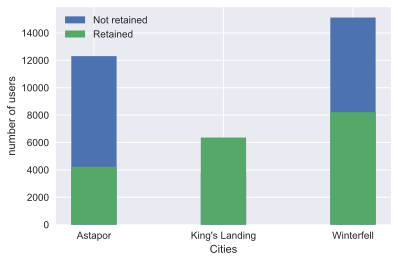

In [25]:
# See the retention rate in different cities
N=3
ind=np.arange(N)
p1=plt.bar(ind, city.iloc[0,:], width=0.35)
p2=plt.bar(ind, city.iloc[1,:], width=0.35)
plt.xticks(ind, city.columns.tolist())
plt.legend((p1[0], p2[0]), ('Not retained', 'Retained'))
plt.xlabel('Cities')
plt.ylabel('number of users')
plt.show()

Wow, all users from King's Landing Cities were retained! That's a very strong predictor.

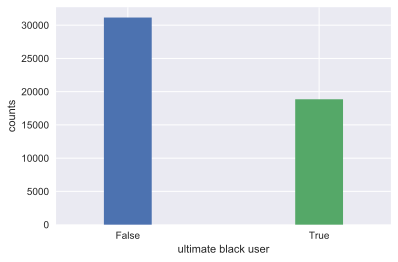

In [30]:
# Now let's look at the ultimate black users, how many of those retained?
cohort['ultimate_black_user'].value_counts().plot.bar(width=0.25)
plt.xticks(rotation=0)
plt.xlabel('ultimate black user')
plt.ylabel('counts')
plt.show()

In [31]:
# Let's take a look at the phone types
black=cohort.groupby('ultimate_black_user')['retained'].value_counts().unstack(level=0)

In [32]:
black

ultimate_black_user,False,True
retained,,
0,21839,9357
1,9307,9497


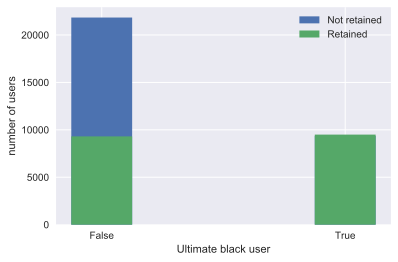

In [34]:
# See the retention rate in different cities
N=2
ind=np.arange(2)
p1=plt.bar(ind, black.iloc[0,:], width=0.25)
p2=plt.bar(ind, black.iloc[1,:], width=0.25)
plt.xticks(ind, black.columns.tolist())
plt.legend((p1[0], p2[0]), ('Not retained', 'Retained'))
plt.xlabel('Ultimate black user')
plt.ylabel('number of users')
plt.show()

Again! All ultimate black users retained!

Next, I will look at the numeric features.

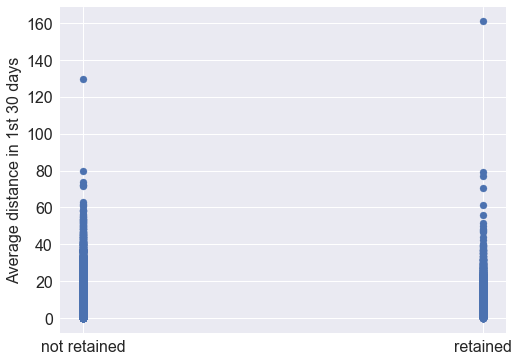

In [14]:
# Average distance in the 1st 30 days
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['avg_dist'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Average distance in 1st 30 days', fontsize=16)
plt.show()

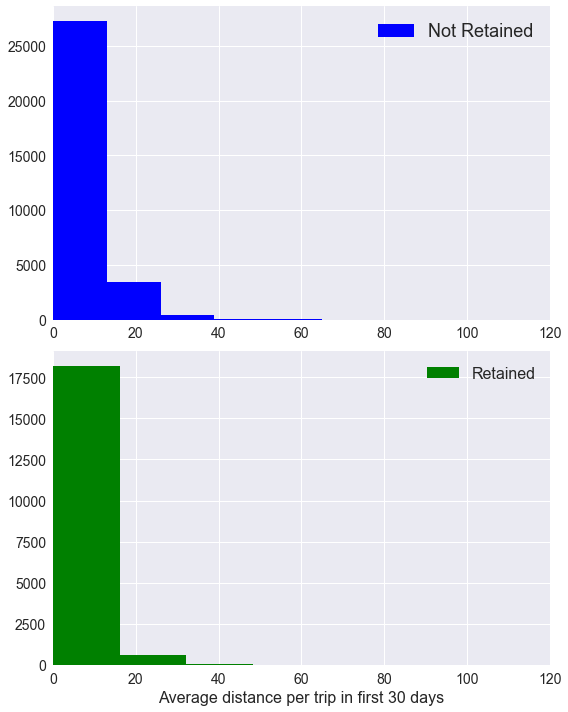

In [20]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['avg_dist'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax1.set_xlim((0, 120))
ax2.hist(cohort[cohort['retained']==1]['avg_dist'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Average distance per trip in first 30 days', fontsize=16)
ax2.set_xlim((0, 120))
plt.tight_layout()
plt.show()

There is not much difference in the distribution of average distance of mile in the 1st 30 days after sign up.

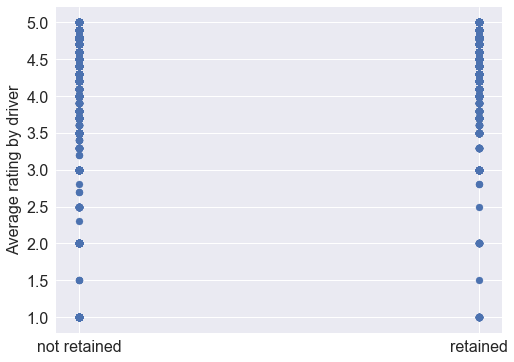

In [13]:
# Average rating by driver
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['avg_rating_by_driver'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Average rating by driver', fontsize=16)
plt.show()

Looks like in the retained users, the ratings are generally higher.

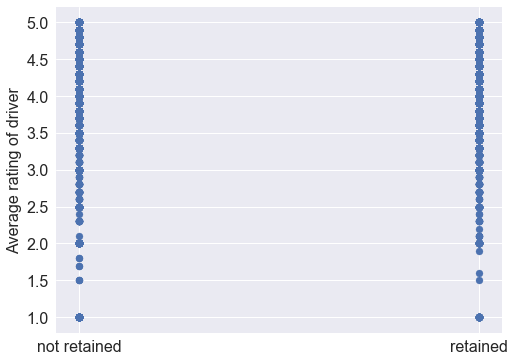

In [15]:
# Average rating of driver
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['avg_rating_of_driver'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Average rating of driver', fontsize=16)
plt.show()

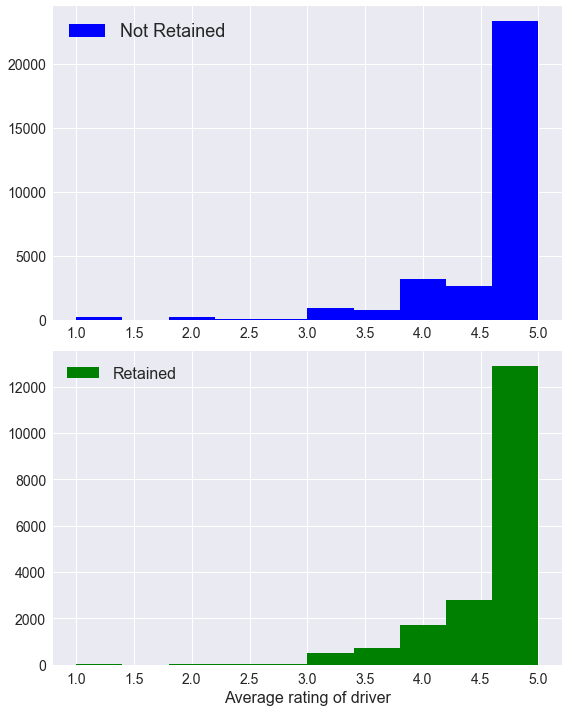

In [22]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['avg_rating_of_driver'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax2.hist(cohort[cohort['retained']==1]['avg_rating_of_driver'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Average rating of driver', fontsize=16)
plt.tight_layout()
plt.show()

This is not a strong predictor.

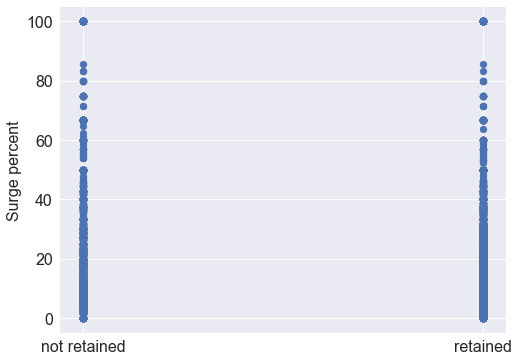

In [16]:
# Surge percent
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['surge_pct'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Surge percent', fontsize=16)
plt.show()

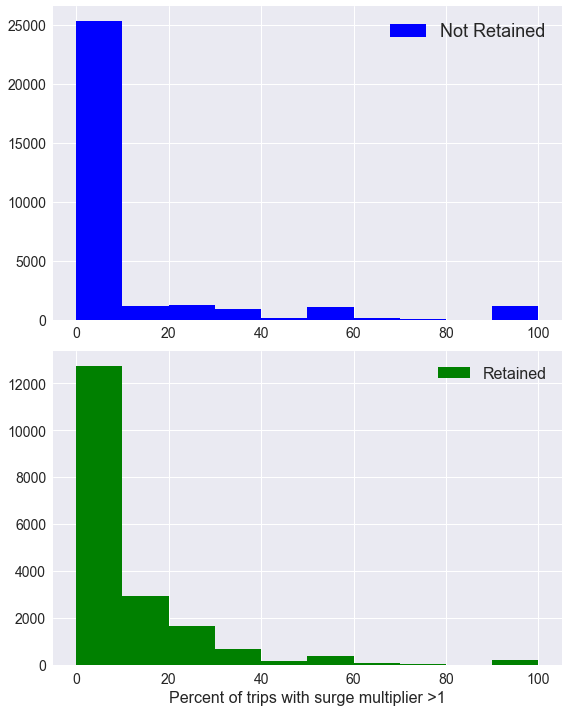

In [24]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['surge_pct'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax2.hist(cohort[cohort['retained']==1]['surge_pct'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Percent of trips with surge multiplier >1', fontsize=16)
plt.tight_layout()
plt.show()

This is not a very strong predictor.

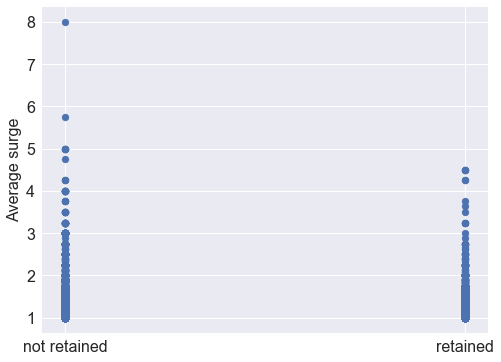

In [17]:
# Average surge
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['avg_surge'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Average surge', fontsize=16)
plt.show()

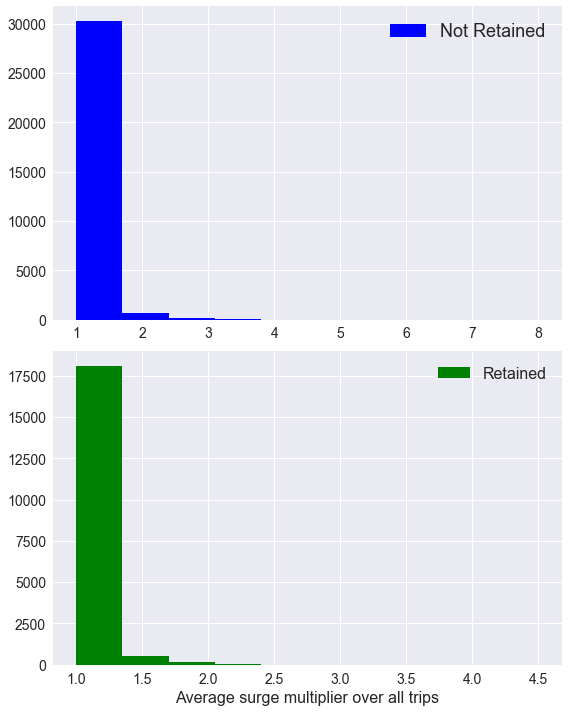

In [25]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['avg_surge'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax2.hist(cohort[cohort['retained']==1]['avg_surge'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Average surge multiplier over all trips', fontsize=16)
plt.tight_layout()
plt.show()

Even though for not retained users, there are several data points that are high but the majority are the same as retained.

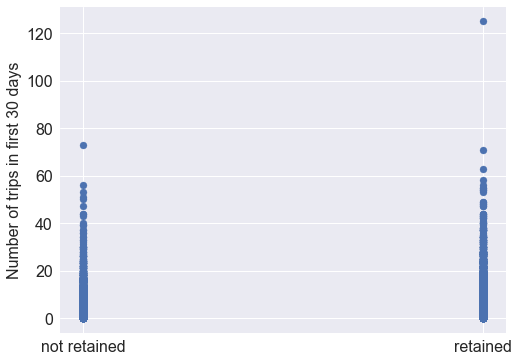

In [18]:
# Trips in first 30 days
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['trips_in_first_30_days'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Number of trips in first 30 days', fontsize=16)
plt.show()

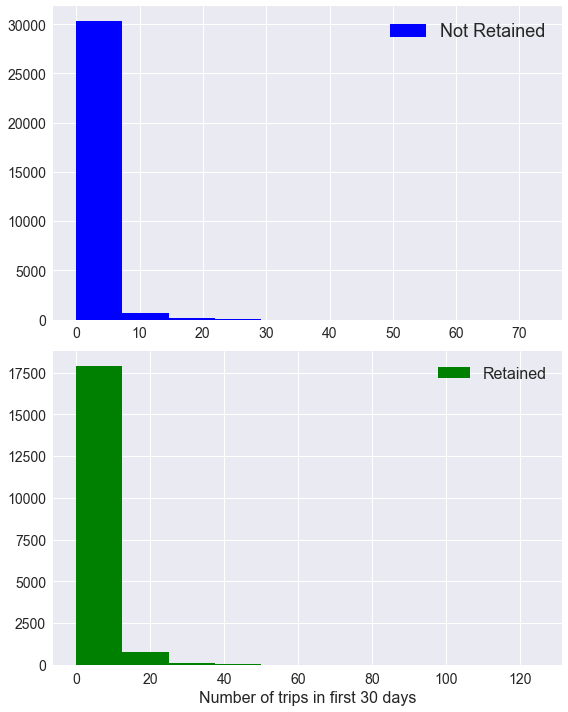

In [26]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['trips_in_first_30_days'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax2.hist(cohort[cohort['retained']==1]['trips_in_first_30_days'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Number of trips in first 30 days', fontsize=16)
plt.tight_layout()
plt.show()

Not much different.

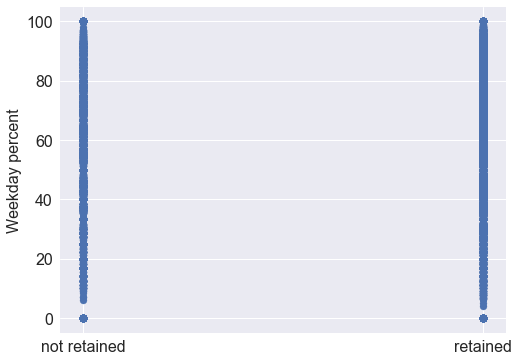

In [19]:
# Weekday percentage
plt.figure(figsize=(8,6))
plt.scatter(cohort['retained'], cohort['weekday_pct'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(2), ['not retained', 'retained'])
plt.ylabel('Weekday percent', fontsize=16)
plt.show()

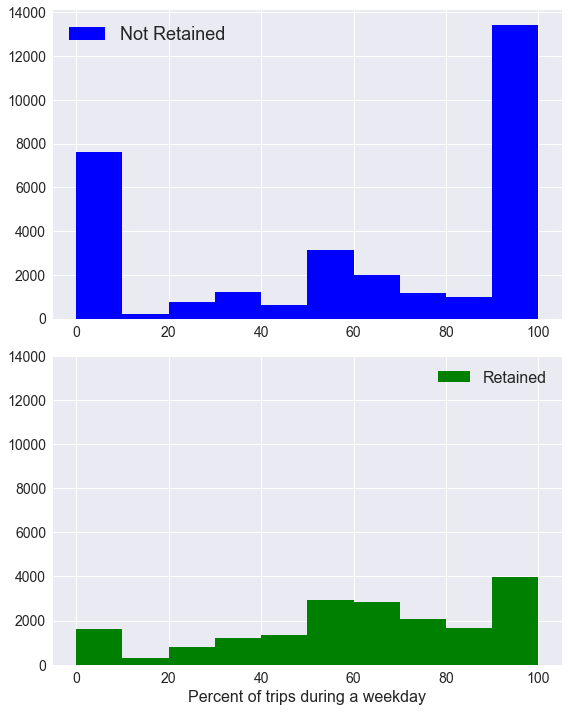

In [28]:
fig, (ax1, ax2)=plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.hist(cohort[cohort['retained']==0]['weekday_pct'], label='Not Retained', color='b')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18)
ax2.hist(cohort[cohort['retained']==1]['weekday_pct'], label='Retained', color='g')
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.legend(fontsize=16)
ax2.set_xlabel('Percent of trips during a weekday', fontsize=16)
ax2.set_ylim((0, 14000))
plt.tight_layout()
plt.show()

Most non retainers took a trip during a weekday. This could be used as a predictor.

After doing the EDA, I decided to use all the categorical features:<br>
'city', 'phone', 'ultimate_black_user' and <br>
numeric features: <br>
'avg_rating_by_driver', 'weekday_pct' <br>
I will try difference classifiers such as logisticregression, linearSVC and randomforest etc.

First transform categorical features into labels using labelencoder

In [29]:
le=LabelEncoder()
for cat in ['phone', 'city', 'ultimate_black_user']:
    cohort[cat+' label']=le.fit_transform(cohort[cat])

In [52]:
data_df=cohort.copy()[['phone label', 'city label', 'ultimate_black_user label', 'avg_rating_by_driver', 
                       'weekday_pct', 'retained']]

In [53]:
data_df.head()

,phone label,city label,ultimate_black_user label,avg_rating_by_driver,weekday_pct,retained
0,1,1,1,5.0,46.2,1
1,0,0,0,5.0,50.0,0
2,1,0,0,5.0,100.0,0
3,1,1,1,4.9,80.0,1
4,0,2,0,4.9,82.4,0


In [54]:
data_df.to_csv('ultimate_challenge/data_for_ml.csv')

In [2]:
#7-4-18
data_df=pd.read_csv('ultimate_challenge/data_for_ml.csv', index_col=0)

In [55]:
hot_encoder=OneHotEncoder()

In [34]:
cat_features=hot_encoder.fit_transform(data_df[['phone label', 'city label', 'ultimate_black_user label']].values)

In [56]:
scaler=StandardScaler()

In [57]:
num_features=scaler.fit_transform(data_df[['avg_rating_by_driver', 'weekday_pct']])

In [58]:
num_features.shape

(50000, 2)

In [59]:
num_features[5, :]

array([0.49768363, 1.05374117])

In [60]:
all_features=scipy.sparse.hstack((cat_features, num_features), format='csr')

In [61]:
all_features.shape

(50000, 10)

In [62]:
#7-3-18
joblib.dump(all_features, 'ultimate_challenge/all_features.pkl')

['ultimate_challenge/all_features.pkl']

In [3]:
#7-4-18
all_features=joblib.load('ultimate_challenge/all_features.pkl')

In [4]:
X=all_features
y=data_df['retained'].values

In [5]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y)

In [7]:
c_values=[0.0001, 0.01, 0.1, 1, 10, 100]

In [74]:
for c in c_values:
    lr=LogisticRegression(class_weight='balanced', C=c)
    lr.fit(X_train, y_train)
    print('Score for C value of', str(c), 'is', lr.score(X_test, y_test))

Score for C value of 0.0001 is 0.66024
Score for C value of 0.01 is 0.66232
Score for C value of 0.1 is 0.66256
Score for C value of 1 is 0.66256
Score for C value of 10 is 0.66256
Score for C value of 100 is 0.66256


In [66]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
lr.score(X_test, y_test)

0.66256

In [80]:
param_grid={'C': c_values}

In [81]:
logreg=LogisticRegression(class_weight='balanced')

In [82]:
logreg_cv=GridSearchCV(logreg, param_grid, cv=5)

In [83]:
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
logreg_cv.cv_results_['mean_test_score']

array([0.67389333, 0.67581333, 0.67597333, 0.676     , 0.676     ,
       0.676     ])

In [8]:
clf=RandomForestClassifier(n_estimators=100)

In [9]:
param_grid = {"max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

In [10]:
# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(clf, parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train, y_train)

    plt.subplot(3,2,index)
    plot = plt.plot(num_range, grid_search.cv_results_['mean_test_score'])
    plt.title(parameter)
    return(plot)

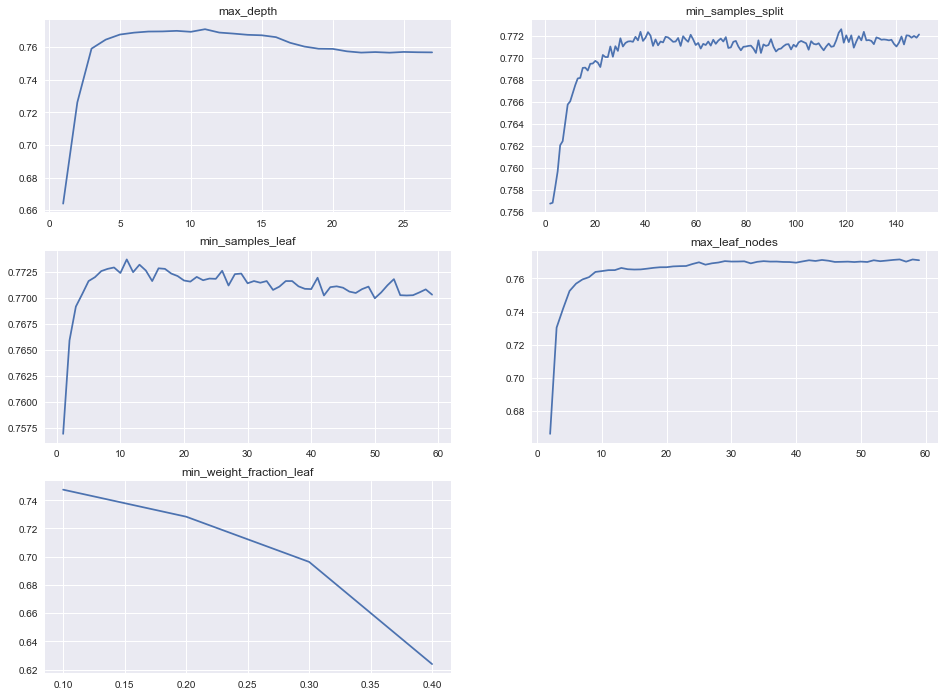

In [11]:
index = 1
plt.figure(figsize=(16,12))
parameters=[]
param_ranges=[]
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(clf, parameter, param_range, index)
    index += 1
plt.show()

In [17]:
# From above figures, narrow down range for each parameter
best_params={'max_depth': [10, 11],
             'min_samples_split': [38, 41, 118],
             'min_samples_leaf': [11, 13],
             'max_leaf_nodes': [58, 59],
             'min_weight_fraction_leaf': [0.1]}

In [21]:
rfc_cv=GridSearchCV(clf, best_params)

In [22]:
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 11], 'min_samples_split': [38, 41, 118], 'min_samples_leaf': [11, 13], 'max_leaf_nodes': [58, 59], 'min_weight_fraction_leaf': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
rfc_cv.best_score_

0.7518666666666667

In [24]:
rfc_cv.best_params_

{'max_depth': 11,
 'max_leaf_nodes': 58,
 'min_samples_leaf': 11,
 'min_samples_split': 38,
 'min_weight_fraction_leaf': 0.1}

In [27]:
rfc_scores=[]
for n in [100, 200, 300, 400, 500]:
    rfc_new=RandomForestClassifier(n_estimators=n,
                                   max_depth=11,
                                   max_leaf_nodes=58,
                                   min_samples_leaf=11,
                                   min_samples_split=38,
                                   min_weight_fraction_leaf=0.1)
    rfc_new.fit(X_train, y_train)
    rfc_scores.append(rfc_new.score(X_test, y_test))

In [28]:
rfc_scores

[0.7584, 0.75208, 0.74976, 0.7484, 0.74952]

In [29]:
dtc=DTC()

In [30]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
dtc.score(X_test, y_test)

0.754

In [12]:
for i in range(1, 100):
    knn=KNN(i)
    knn.fit(X_train, y_train)
    print('n_neighbors=', str(i), ' give a score of ', knn.score(X_test, y_test))

n_neighbors= 1  give a score of  0.65816
n_neighbors= 2  give a score of  0.71792
n_neighbors= 3  give a score of  0.7344
n_neighbors= 4  give a score of  0.7524
n_neighbors= 5  give a score of  0.75536
n_neighbors= 6  give a score of  0.7616
n_neighbors= 7  give a score of  0.76376
n_neighbors= 8  give a score of  0.76208
n_neighbors= 9  give a score of  0.76552
n_neighbors= 10  give a score of  0.766
n_neighbors= 11  give a score of  0.76584
n_neighbors= 12  give a score of  0.76656
n_neighbors= 13  give a score of  0.7684
n_neighbors= 14  give a score of  0.76672
n_neighbors= 15  give a score of  0.76968
n_neighbors= 16  give a score of  0.76696
n_neighbors= 17  give a score of  0.76776
n_neighbors= 18  give a score of  0.76616
n_neighbors= 19  give a score of  0.76656
n_neighbors= 20  give a score of  0.76712
n_neighbors= 21  give a score of  0.7684
n_neighbors= 22  give a score of  0.76728
n_neighbors= 23  give a score of  0.76712
n_neighbors= 24  give a score of  0.76728
n_neighb

In [76]:
linearsvc=LinearSVC(class_weight='balanced')

In [77]:
linearsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [78]:
linearsvc.score(X_test, y_test)

0.66232

In [82]:
gbc=GBC()

In [83]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [84]:
gbc.score(X_test, y_test)

0.75344

In [85]:
adc=AdaBoostClassifier()

In [86]:
adc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [87]:
adc.score(X_test, y_test)

0.75072

In [34]:
mlp=MLPClassifier(hidden_layer_sizes=(100,3))

In [89]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [90]:
mlp.score(X_test, y_test)

0.7376

In [33]:
for c in c_values:
    svc=SVC(C=c)
    svc.fit(X_train, y_train)
    print(svc.score(X_test, y_test))

0.62392
0.75064
0.75496
0.75976
0.76328
0.76664


In [35]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    svc=SVC(C=100, gamma=gamma)
    svc.fit(X_train, y_train)
    print(svc.score(X_test, y_test))

0.75312
0.75296
0.76664
0.77264
0.76712
0.76352


<b>So far the best model is SVC with a C value of 100 and gamma of 1 with a score of 0.77. I will perform cross validation to best fit the training data.

In [28]:
svc=SVC(C=100, gamma=1, probability=True)

In [29]:
params_grid={'C':[10], 'gamma':[1]}

In [30]:
svc_cv=GridSearchCV(svc, params_grid, cv=5)

In [31]:
svc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [10], 'gamma': [1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [32]:
svc_cv.best_score_

0.7672

In [33]:
svc_cv.score(X_test, y_test)

0.77408

In [34]:
# I will use precision and recall and f1 score as my metrics
preds=svc_cv.predict(X_test)

In [35]:
print(classification_report(y_test, preds, target_names=['Not retained', 'Retained']))

              precision    recall  f1-score   support

Not retained       0.80      0.85      0.82      7799
    Retained       0.73      0.64      0.68      4701

 avg / total       0.77      0.77      0.77     12500



In [44]:
y_pred_prob=svc_cv.predict_proba(X_test)

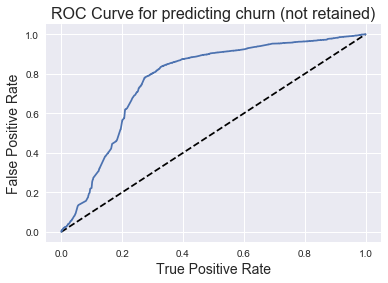

In [50]:
# Now I am going to plot an ROC curve for the prediction for people who will not retain
# Compute predicted probabilities: y_pred_prob
y_pred_prob_churned = y_pred_prob[:,0]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_churned)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr, fpr)
plt.xlabel('True Positive Rate', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.title('ROC Curve for predicting churn (not retained)', fontsize=16)
plt.show()

In [54]:
print('Area under curve is:', round(auc(tpr, fpr), 3))

Area under curve is: 0.771


<b>From the model and EDA above, we can see that the factors that affect are 'city', 'phone', 'ultimate_black_user', 'avg_rating_by_driver' and 'weekday_pct'. The kernel I used for my svm is not linear so it's not possible to interpret the feature importance in my model. However, the EDA strongly suggests the above featuers contribute to user retainment. I would make following suggestions: <br>
(a) Advertise more in the city of King's Landing Cities<br>
(b) Increase iphone user base by adding incentives (we don't know why Android users are less likely to be retained but that's worth further investigation with more data)<br>
(c) Try to convert more users to Ultimate Black User tier by offering incentives<br>
(d) Increase performance of drivers